## Import modules

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler # to scale and center data
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV # to perform cross-validation
from sklearn.metrics import confusion_matrix , accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA # to perform PCA
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Dataset Information
________________________


This dataset belongs to [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/) and you can find the data [here](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients).The aim of this project is to build a SupportVectorMachine algorithm aimed at the case of customers' default payments in Taiwan. Default payment (Yes = 1, No = 0), as the response variable. This project reviewed the literature and used the following 23 variables as explanatory variables

Our dataset contain 30,000 rows 

## Variable Information
_________________________
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.


X2: Gender (1 = male; 2 = female).


X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).


X4: Marital status (1 = married; 2 = single; 3 = others).


X5: Age (year).

### History of past payment

X6 - X11. We tracked the past monthly payment records (from April to September, 2005) as follows:

X6 = the repayment status in September, 2005;

X7 = the repayment status in August, 2005;

. . .;X11 = the repayment status in April, 2005.

### The measurement scale for the repayment status
-1 = pay duly;

1 = payment delay for one month;

2 = payment delay for two months; . . .;

8 = payment delay for eight months;

9 = payment delay for nine months and above.

### Amount of bill statement (NT dollar)
X12-X17

X12 = amount of bill statement in September, 2005;

X13 = amount of bill statement in August, 2005; . . .;

X17 = amount of bill statement in April, 2005.

### Amount of previous payment (NT dollar)

X18-X23

X18 = amount paid in September, 2005;

X19 = amount paid in August, 2005; . . .;

X23 = amount paid in April, 2005.
_______________________________________________
#### Is Our data Has Missing Values?

**No**

In [5]:
!pip install ucimlrepo

## Loading our data

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
features = default_of_credit_card_clients.data.features
targets = default_of_credit_card_clients.data.targets

#### Concatinating our features and target variables

In [7]:
df = pd.concat([features, targets], axis=1)

In [8]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Data perprocessing
___________________
**It's worth to mention that this data is very clean so a lot of preprocessing have been done on it like feature engineering, data cleaning, so what left to us to do is very little**

In [9]:
# Now I know that education feature X3 contains more than the allowed values (1 = graduate school; 2 = university; 3 = high school; 4 = others). It also contains (5,6,0).
df['X3'].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [10]:
df['X4'].unique()

array([1, 2, 3, 0])

#### It looks like the 0 in the dataset represent misssing values I guess!. I will deal with it too.

> Now we want to know how many missing values we have in these features



In [11]:
len(df.loc[(df['X3'] == 0) | (df['X4'] == 0)])

68

**Since our dataset have 30,000 rows I guess that if we removed the 68 won't hurt us, but defintley there's another way we can solve the problem of missing values with.**


In [12]:
df_no_missing = df.loc[(df['X3'] != 0) & (df['X4'] != 0)]
# Verfying we removed the missing data
len(df_no_missing)

29932

#### Check our features after cleaning


In [13]:
# Check our education feature
df_no_missing['X3'].unique()

array([2, 1, 3, 5, 4, 6])

In [14]:
# Check our marriage feature.
df_no_missing['X4'].unique()

array([1, 2, 3])

#### Look at the datat statstics

In [15]:
df_no_missing.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
count,29932.000000,29932.000000,29932.000000,29932.000000,29932.000000,29932.000000,29932.000000,29932.000000,29932.000000,29932.000000,...,29932.000000,29932.00000,29932.000000,29932.000000,2.993200e+04,29932.000000,29932.000000,29932.000000,29932.000000,29932.000000
mean,167523.375651,1.603568,1.852399,1.554590,35.479721,-0.016203,-0.133235,-0.165776,-0.220099,-0.265569,...,43320.699452,40367.54861,38927.267072,5659.603034,5.923502e+03,5226.158760,4830.180075,4805.269310,5221.906421,0.221535
std,129821.209970,0.489164,0.788941,0.518277,9.219044,1.123450,1.196990,1.196386,1.168849,1.133057,...,64385.857098,60845.48775,59601.231051,16555.874642,2.306020e+04,17620.773728,15680.849676,15294.066811,17795.285035,0.415287
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.00000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2339.750000,1772.75000,1261.000000,1000.000000,8.360000e+02,390.000000,298.000000,255.000000,122.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19068.500000,18125.50000,17111.500000,2100.000000,2.010000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54613.250000,50253.50000,49260.250000,5006.000000,5.000000e+03,4507.250000,4015.000000,4040.250000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.00000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [16]:
df_no_missing['X1']

0         20000
1        120000
2         90000
3         50000
4         50000
          ...  
29995    220000
29996    150000
29997     30000
29998     80000
29999     50000
Name: X1, Length: 29932, dtype: int64

## Data visualization
#### Let's explore some of our variables using visualization techniques

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


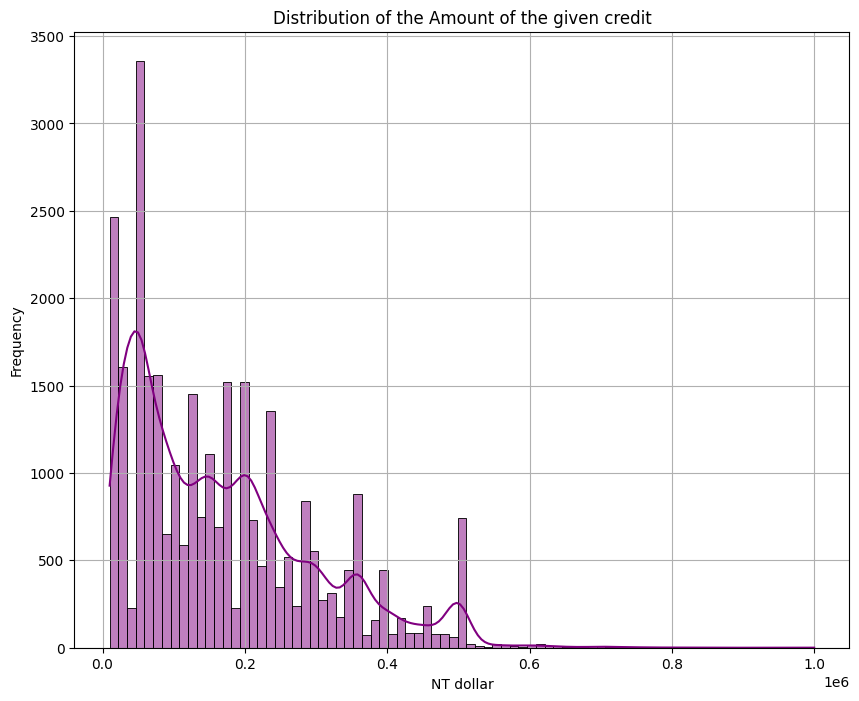

In [17]:
# histogram to explore our target variable how many defaulted and how many do not default
plt.figure(figsize=(10, 8))
sns.histplot(data = df_no_missing['X1'], color ='purple', kde=True)
plt.title('Distribution of the Amount of the given credit')
plt.xlabel('NT dollar')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
bill_statements = df_no_missing.loc[:, 'X12':'X17']
bill_statements.rename(columns={'X12': 'September, 2005', 'X13': 'August, 2005', 'X14': 'July, 2005', 'X15': 'June, 2005','X16': 'May, 2005', 'X17': 'April, 2005'}, inplace=True)
bill_statements

,"September, 2005","August, 2005","July, 2005","June, 2005","May, 2005","April, 2005"
0,3913,3102,689,0,0,0
1,2682,1725,2682,3272,3455,3261
2,29239,14027,13559,14331,14948,15549
3,46990,48233,49291,28314,28959,29547
4,8617,5670,35835,20940,19146,19131
...,...,...,...,...,...,...
29995,188948,192815,208365,88004,31237,15980
29996,1683,1828,3502,8979,5190,0
29997,3565,3356,2758,20878,20582,19357
29998,-1645,78379,76304,52774,11855,48944


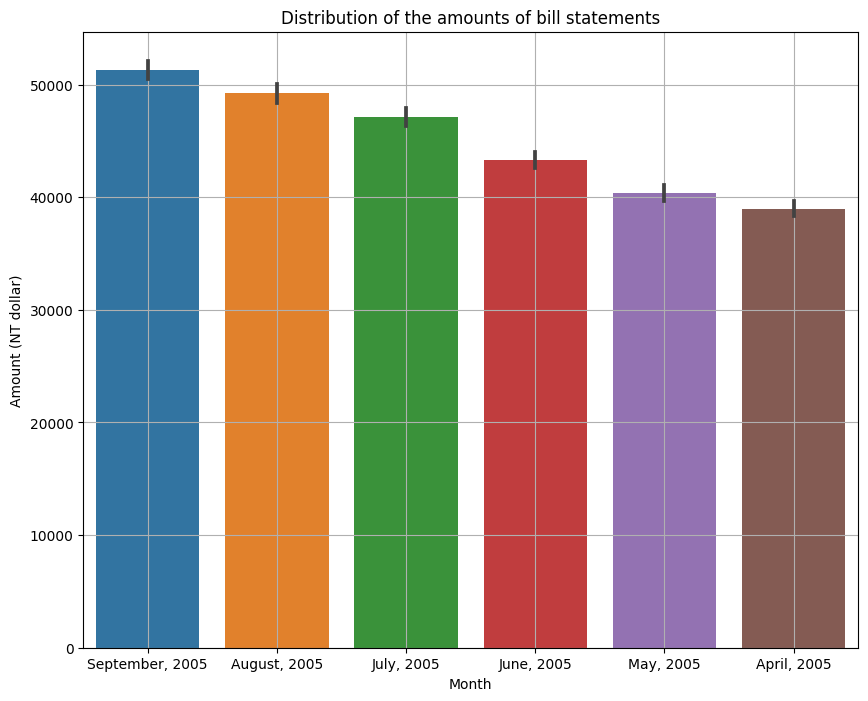

In [19]:
plt.figure(figsize=(10, 8))
sns.barplot(data=bill_statements)
plt.title('Distribution of the amounts of bill statements')
plt.xlabel('Month')
plt.ylabel('Amount (NT dollar)')
plt.grid(True)
plt.show()

**let's count the number of zeros and ones we have in our target feature to further analysis it**


In [20]:
print("Number of zeros: ", df_no_missing['Y'].value_counts().get(0, 0))
print("Number of ones: ", df_no_missing['Y'].value_counts().get(1, 0))

Number of zeros:  23301
Number of ones:  6631


#### Let's now seperate our features and target variables to prepare it for our model

In [21]:
X = df_no_missing.drop('Y', axis=1).copy()

In [22]:
y = df_no_missing['Y'].copy()

**Now our radial basis function assumes that our data are scaled so we have to scale it**

there's a varaiety of methods used to scale the data like

- min-max
- absloute-max
- normalization
- roboust scalers

I will work with **robust scalers** as it's more robust to outliers than the other methods we can also work with the z-score but I go with the robust scaler

_____________
#### Let's first split our data into a training set and testing set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

## Scaling the data

In [24]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Building the SVM model

In [51]:
classifier = SVC(random_state = 42)
classifier.fit(X_train_scaled, y_train)

SVC(random_state=42)

#### Let's do our prediction

In [52]:
y_pred = classifier.predict(X_test_scaled)

## Build ConfusionMatrix and accuracy score

In [53]:
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
print(cm)
accuracy_score(y_test, y_pred)

[[5594  246]
 [1131  512]]


0.8159828945610049

#### Let's display our confusion matrix too

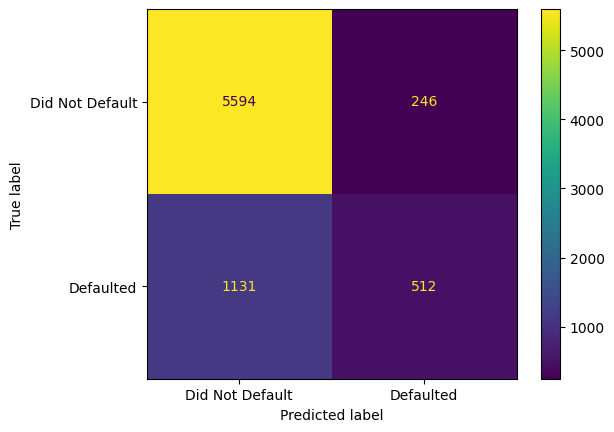

In [54]:
disp = ConfusionMatrixDisplay(cm, display_labels=["Did Not Default", "Defaulted"])
disp.plot()
plt.show()

And the result from the optimized **SupportVectorMachine** is 5594 predicted as did not default or 95%, And we have 512 predicted as default or 31%.

**Build our Cross-Validation and GridSearchCV to tell us which combination of params we should use to enhance our model. An important note here that we didn't downsampled our data and with the 30,000 rows the GridSearchCV will take a long time in training and to solve this we should downsample the data to make it faster it was okay for me so I didn't go with this option**

## Build Cross-Validation and GridSearchCV

In [ ]:
param_grid = [{
    'C' : [0.5, 1, 10, 100],
    'gamma' : ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel' : ['rbf']}
              ]
optimal_params = GridSearchCV(SVC(),
                              param_grid,
                              cv=5,
                              scoring='accuracy')
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

#### Building a better version using what **GridSearchCV** come up with

kernel = 'rbf', C = 10, gamma = 0.01

In [47]:
classifier = SVC(random_state = 42, C=10, gamma=0.01)
classifier.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.01, random_state=42)

In [48]:
y_pred = classifier.predict(X_test_scaled)

In [49]:
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
print(cm)
accuracy_score(y_test, y_pred)

[[5589  251]
 [1122  521]]


0.8165174395296004

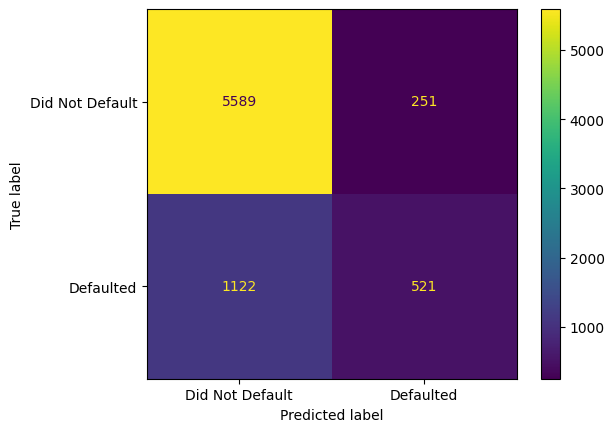

In [50]:
disp = ConfusionMatrixDisplay(cm, display_labels=["Did Not Default", "Defaulted"])
disp.plot()
plt.show()

## Result

After enhancing some of our parameters using GridSearchCV now we see that there's a littler importvment with 9 more clients predicted as default, and 5 more people who missclassied as default while they're did not default, and this improved our overall accuracy score by 0.0006% it sounds it did not do very well and our model performance is good but not very good actullay a nice try but I see opportunity for improvment maybe let's share with me your thoughts about that please.

Let's draw a Support vector machine decision boundary and discuss how interpert it.

Let's first examine how many columns we have in the dataset

In [55]:
len(df_no_missing.columns)

24

We have 24 features and that's a problem because it woul require a 24 dimenosional graph, one dimension per feature used to make predictions, to plot the data in it's raw form, so we will use **Principal Component Analysis** to combine the 24 features into 2 orthognal meta features that we can use as axes for a graph. We will shrink all the columns into two columns 

##### First we will draw a scree plot which will show how good the approximation of the true classifier is, what we would like is the first two component to be taller than the others, which means that this two columns we will use is accuratlley will reflect the original data

## PCA

I can say that with this number of data we have our training will be too slow for the GridSearchCV and it should be downsampled now to be able to train faster

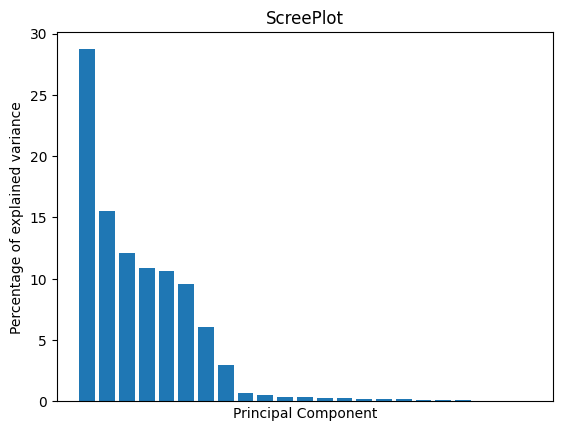

In [58]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range (1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Component')
plt.title('ScreePlot')
plt.show()

In [ ]:
train_pca1 = X_train_pca[:, 0]
train_pca2 = X_train_pca[:, 1]

pca_train_scaled = scaler.fit_transform(np.column_stack((train_pca1, train_pca2)))

param_grid = [{
    'C' : [1, 10, 100, 1000],
    'gamma' : ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel' : ['rbf']}
              ]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

In [ ]:
clf_svm = SVC(random_state=42, C= 10, gamma=0.01)
clf_svm.fit(pca_train_scaled, y_train)

X_test_pca = pca.transform(X_train_scaled)

test_pca1 = X_test_pca[:, 0]
test_pca2 = X_test_pca[:, 1]

x_min = test_pca1.min()-1
x_max = test_pca1.max()+1

y_min = test_pca2.min()-1
y_max = test_pca2.max()+1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                    np.arange(start=y_min, stop=y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, Z, alpha=0.1)

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pca1, test_pca2, c=y_train,
                    cmap=cmap,
                    s=100,
                    edgecolors='k',
                    aplha=0.7)

legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elemetns()[1],
                  loc=="upper_right")

legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision Boundary using PCA projected feature')

plt.show()

## Conclusion

First I started with importing the data and it was cleaned somehow and save a lot of time on me from preprocessing it but there still was some preprocessing and the data wasn't that big so it didn't take a lot of time from me just cleaning some missing values then after that I started visualizing the data to explore it more. I then moved to spliting the targets and features away from the original dataframe, then started to split them into training and testing sets. Then built the model and built the ConfusionMatrix and accuracy score we scored a 81.5% in accuracy. After building the gridsearch to hypertuning our parameters the accuracy scored a 0.0006% improvment not that bad right! :), then I developed a PCA as I wanted to draw a Support vector machine decision boundary but I faced the problem of high dimensionality but our secret weapon **PCA** show at time. In the end it was a fun project but not that much missy data the kind I love. Hope you found it useful

Find out my article about SupportVectorMachine [here](https://medium.com/@abdullah.hosam13/a-comprehensive-guide-to-support-vector-machines-svms-e8d5584434eb)